In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(380)

In [2]:
n_j = np.array([18000, 22000, 50100, 21010, 25000])
od_matrix = np.random.randint(1000, 3000, size=(5, 5))
alpha_vec = np.full(len(n_j), 1)
beta_vec = np.full(len(n_j), 0.8)
gamma_vec = np.full(len(n_j), 0.05)
od_flow = od_flow = od_matrix / od_matrix.sum(axis=1, keepdims=True)
days = 300

array([[0.19774289, 0.17026497, 0.18792934, 0.21156362, 0.23249918],
       [0.21362387, 0.13155483, 0.13786783, 0.23734854, 0.27960493],
       [0.17172938, 0.1914049 , 0.24853297, 0.20762858, 0.18070418],
       [0.22890865, 0.09483833, 0.23979719, 0.20014961, 0.23630621],
       [0.16314309, 0.23001543, 0.26721713, 0.11596044, 0.22366391]])

In [3]:
'''initial_infected = n_j * np.array([0.01, 0.005, 0.01, 0, 0])
initial_status = n_j * np.array([0.99, 0.995, 0.99, 1, 1])
# initial_status

sir_sim = np.transpose(np.array([initial_status, initial_infected, np.zeros((5))]))'''

def start_detect(n_j, infect, immune):
    sir = np.zeros((len(n_j), 3))
    sir[:, 0] = n_j - infect - immune  # Susceptible
    sir[:, 1] = infect  # Infected
    sir[:, 2] = immune  # Recovered
    return sir

infect = np.array([0.01, 0.005, 0.001, 0, 0]) * n_j
immune = np.zeros(len(n_j))
sir = start_detect(n_j, infect, immune)


In [4]:
def epidemic_sim(n_j, initial_status, od_flow, 
                 alpha_vec, beta_vec, gamma_vec, days):
    sir_sim = initial_status.copy()
    susceptible_pop_norm = []
    infected_pop_norm = []
    recovered_pop_norm = []
    
    total_days = np.linspace(1, days, days)
    for day in total_days:
        sir_percent = sir_sim / n_j[:, None]
        infected_mat = np.outer(sir_percent[:, 1], np.ones(len(n_j)))
        od_infected = od_flow * infected_mat
        inflow_infected = od_infected.sum(axis=0)
        inflow_infected = inflow_infected * alpha_vec
        
        # Adjusted new infection calculation
        s_j_t = sir_sim[:, 0]
        N_j = n_j
        m_j_t_k = od_flow
        m_k_t_j = od_flow.T
        i_k_t = sir_sim[:, 1]
        
        new_infect = alpha_vec * (s_j_t / (N_j + m_j_t_k.sum(axis=1) - m_k_t_j.sum(axis=0))) * (od_flow @ i_k_t) * beta_vec
        new_infect = np.minimum(new_infect, sir_sim[:, 0])
        
        new_recovered = gamma_vec * sir_sim[:, 1]
        
        sir_sim[:, 0] -= new_infect
        sir_sim[:, 1] += new_infect - new_recovered
        sir_sim[:, 2] += new_recovered
        
        sir_sim = np.maximum(sir_sim, 0)
        
        region_sum = sir_sim.sum(axis=0)
        region_sum_normalized = region_sum / n_j.sum()
        s = region_sum_normalized
        i = region_sum_normalized
        r = region_sum_normalized
        
        susceptible_pop_norm.append(s)
        infected_pop_norm.append(i)
        recovered_pop_norm.append(r)
        
    return [susceptible_pop_norm, infected_pop_norm, recovered_pop_norm]


<Figure size 1000x800 with 0 Axes>

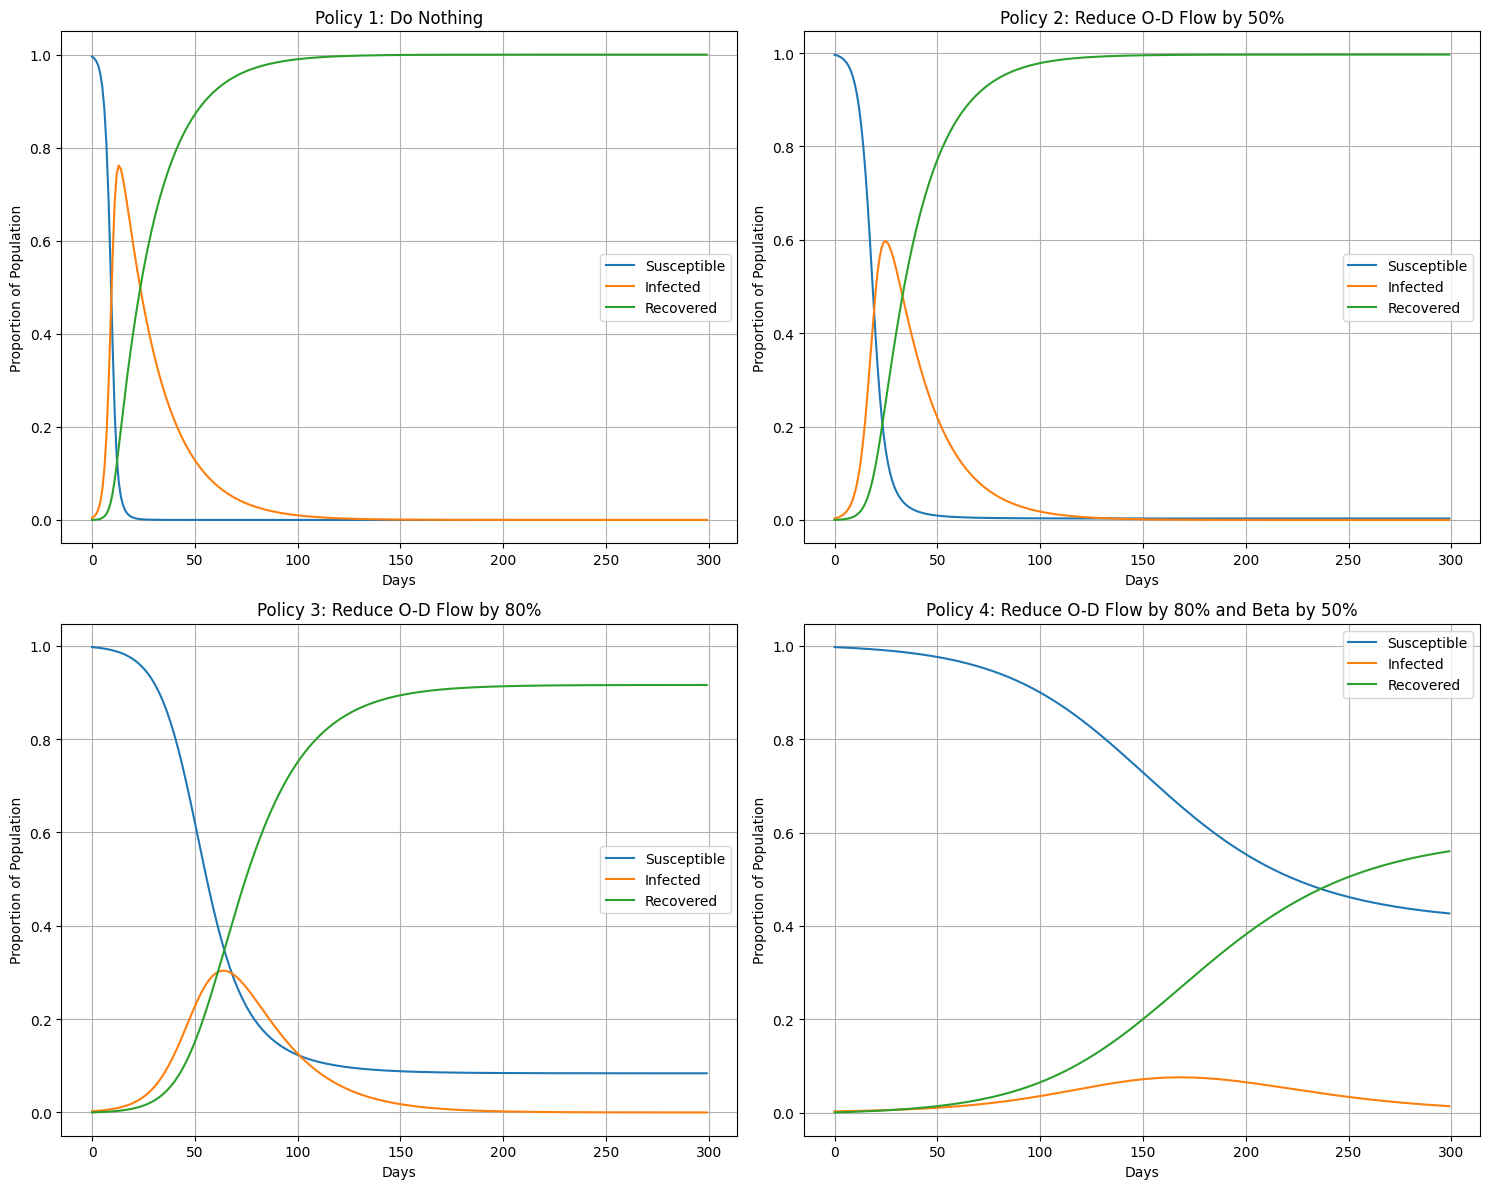

In [19]:
def policy_evaluation(n_j, sir, od_flow, alpha_vec, beta_vec, gamma_vec, days):
    # Policy 1: Do nothing (baseline)
    outcome1 = epidemic_sim(n_j, sir, od_flow, alpha_vec, beta_vec, gamma_vec, days)
    
    # Policy 2: Reduce the O-D flow by 50%
    od_flow_policy2 = od_flow * 0.5
    outcome2 = epidemic_sim(n_j, sir, od_flow_policy2, alpha_vec, beta_vec, gamma_vec, days)
    
    # Policy 3: Reduce the O-D flow by 80%
    od_flow_policy3 = od_flow * 0.2
    outcome3 = epidemic_sim(n_j, sir, od_flow_policy3, alpha_vec, beta_vec, gamma_vec, days)
    
    # Policy 4: Reduce the O-D flow by 80% and reduce beta by 50%
    od_flow_policy4 = od_flow * 0.2
    beta_vec_policy4 = beta_vec * 0.5
    outcome4 = epidemic_sim(n_j, sir, od_flow_policy4, alpha_vec, beta_vec_policy4, gamma_vec, days)
    
    # Visualize the results
    fig = plt.figure(figsize=(10, 8))

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot for Policy 1
    axs[0, 0].plot(range(days), outcome1[0])
    axs[0, 0].set_title('Policy 1: Do Nothing')
    axs[0, 0].set_xlabel('Days')
    axs[0, 0].set_ylabel('Proportion of Population')
    axs[0, 0].legend(['Susceptible', 'Infected', 'Recovered'])
    axs[0, 0].grid(True)
    
    # Plot for Policy 2
    axs[0, 1].plot(range(days), outcome2[0])
    axs[0, 1].set_title('Policy 2: Reduce O-D Flow by 50%')
    axs[0, 1].set_xlabel('Days')
    axs[0, 1].set_ylabel('Proportion of Population')
    axs[0, 1].legend(['Susceptible', 'Infected', 'Recovered'])
    axs[0, 1].grid(True)
    
    # Plot for Policy 3
    axs[1, 0].plot(range(days), outcome3[0])
    axs[1, 0].set_title('Policy 3: Reduce O-D Flow by 80%')
    axs[1, 0].set_xlabel('Days')
    axs[1, 0].set_ylabel('Proportion of Population')
    axs[1, 0].legend(['Susceptible', 'Infected', 'Recovered'])
    axs[1, 0].grid(True)
    
    # Plot for Policy 4
    axs[1, 1].plot(range(days), outcome4[0])
    axs[1, 1].set_title('Policy 4: Reduce O-D Flow by 80% and Beta by 50%')
    axs[1, 1].set_xlabel('Days')
    axs[1, 1].set_ylabel('Proportion of Population')
    axs[1, 1].legend(['Susceptible', 'Infected', 'Recovered'])
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the policy evaluation
policy_evaluation(n_j, sir, od_flow, alpha_vec, beta_vec, gamma_vec, days)
